In [6]:
"""
####################################################################################################################
Program    : calc_zonal_averages_future.ipynb
Usage      : Reads in numpy dictionary containing CMIP6 multi-model monthly precipitation data for a specified 
             region, and calculates the zonal mean for each model for the full time period (historical or future).
             Output is a .npy file containing data for all models.
Written in : Python
Tested on  : JASMIN
Written by : Natalie Lord (natalie.lord@bristol.ac.uk), with some code adapted from script written by Jess Baker (j.c.baker@leeds.ac.uk)  
Date       : 02/06/2021
####################################################################################################################
"""

import os
import numpy as np
import xarray as xr
from datetime import datetime as dt
from pathlib import Path
import iris
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units
from iris.time import PartialDateTime
import iris.analysis.cartography
import cftime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


def make_cmip6_filepath(directory_nam, # scenario, variable, data_type, experiment, region,
                        data_root="/gws/pw/j05/cop26_hackathons/bristol/project02/data"):
    """
    Make a file path for a cmip6 dataset on JASMIN for a single variable
    """
    # get base path
    path = str(DATA_ROOT / directory_nam) # / data_type / model)
    #print(path)
    #print(os.listdir(path))
    
    print('JASMIN FILEPATH:')
    print(path)
    print('DIRECTORY CONTENTS:')
    print(os.listdir(path))
    return(path+ '/')

def make_cmip6_filenam(file_prefix, experiment, variable, latmin, latmax, lonmin, lonmax):
    """
    Make a file path for a cmip6 dataset on JASMIN for a single variable
    """
    file = str(file_prefix + '_' + experiment + '_' + variable + '_dict' + str(latmin) + '_to_' + str(latmax) + 'lat' + '_' + str(lonmin)  + '_to_' + str(lonmax)  + 'lon')
    
    print('JASMIN FILENAM:')
    print(file)
    return(file+ '.npy')

In [7]:
# create dictionary of models and institutes (allows you to loop over models and know the name of the directory that contains the data for that model)
basepath = '/badc/cmip6/data/CMIP6/CMIP/'
institute_list = os.listdir(basepath)
model_inst_dict = {}

# loop over institutes
for inst in institute_list:
    model_list = os.listdir(basepath + inst + '/')
    
    # for each institute list models and store in dictionary
    for model_temp in model_list:
        model_inst_dict[model_temp] = inst
    
    # correction for UKESM which is used by multiple centres - we want MOHC only
    model_inst_dict['UKESM1-0-LL'] = 'MOHC'
    
# print(model_inst_dict)

In [8]:
#assert False  # May want to add this if already saved data into dictionaries to prevent re-writing

# Read in precipitation data over domain for CMIP6 models and save data to dictionary

DATA_ROOT = Path("/gws/pw/j05/cop26_hackathons/bristol/project02/data/")

# dictionary to save subset model output
pr_datasets = {}

# Define region of interest
latmin = -25
latmax = 25
lonmin = 20
lonmax = 30

# variables for JASMIN directory structure
table_id = 'Amon'  # monthly model output
variable_id = 'pr'  # variable code for precipitation in cmip6 model output

# read in monthly zonal data 

# Larger selection of models
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5',
          'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM',
          'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8',
          'MPI-ESM1-2-LR', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'] 

# Subset of models that have SSP119 data available
#models = ['CAMS-CSM1-0', 'CanESM5',
#          'CNRM-ESM2-1', 'FGOALS-g3',
#          'GISS-E2-1-G', 
#          'UKESM1-0-LL'] 

# Try for just one model to see if it works
#models = ['CanESM5']

# Loop over multiple model experiments and calculate SPEI for all, north and south Ghana
for expt in ['ssp585']: #, 'historical', ssp119', 'ssp585']:

    try:
        # get CMIP6 precip data
        if expt == 'historical':
            scenario = 'CMIP'
            file_prefix = 'cmip6'
            directory_nam = str('CMIP6' + 'histo')
            first_yr = 's1850'

#            start_year = 1950 #1950 #2070
#            end_year = 1999 #1999 #2100

        elif expt in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
            scenario = 'CMIP'
            file_prefix = 'cmip6'
            directory_nam = str('CMIP6' + 'proj')
            first_yr = 's2015'
#            scenario = 'ScenarioMIP'

            start_year = 2015 #2070
            end_year = 2100 #2100

#        time_period_subset = str(str(start_year) + '-' + str(end_year))

        # get filepath for data for particular model and variable of interest
        fp_nam_path = make_cmip6_filepath(directory_nam=directory_nam)
        fp_nam_file = make_cmip6_filenam(file_prefix=file_prefix, experiment=expt, variable=variable_id, latmin=latmin, latmax=latmax, lonmin=lonmin, lonmax=lonmax) 
            
        fp_nam = str(str(fp_nam_path) + '/' + fp_nam_file)
            
        # read in data
        pr_data_all = np.load(fp_nam).item()
            
#        print(pr_data_all)
    
    except FileNotFoundError:
        print(model, ' has no ' + expt.upper() + ' output')
        continue


JASMIN FILEPATH:
/gws/pw/j05/cop26_hackathons/bristol/project02/data/CMIP6proj
DIRECTORY CONTENTS:
['TRBindices', 'zonalAverages', 'cmip6_ssp119_pr_dict.npy', 'cmip6_ssp585_pr_dict.npy', 'cmip6_ssp119_pr_dict-25_to_25lat_20_to_30lon.npy', 'cmip6_ssp585_pr_dict-25_to_25lat_20_to_30lon.npy', 'cmip6_ssp119_tas_dict-25_to_25lat_20_to_30lon.npy', 'cmip6_ssp585_tas_dict-25_to_25lat_20_to_30lon.npy', 'cmip6_ssp585_pr_anomalies.npy', 'cmip6_ssp585_tas_anomalies.npy', 'cmip6_ssp119_tas_dict-90_to_90lat_-180_to_180lon.npy', 'cmip6_ssp585_local_tas_anomalies.npy', 'cmip6_ssp585_tas_dict-90_to_90lat_-180_to_180lon.npy', 'cmip6_ssp585_global_tas_anomalies.npy']
JASMIN FILENAM:
cmip6_ssp585_pr_dict-25_to_25lat_20_to_30lon


In [9]:
    for model in models:
        print(model, '', expt.upper())

        # extract data for individual models
        model_time = pr_data_all[model].coord('time')
        model_lat = pr_data_all[model].coord('latitude')
        model_lon = pr_data_all[model].coord('lon')

        # print(pr_data)
        print(model_time)
        print(model_lat)
        print(model_lon)
        
        
        # Calculate zonal average
        pr_cube_zonal_mean = pr_data_all[model].collapsed(['lon'], iris.analysis.MEAN)
        print(pr_cube_zonal_mean)


        if model == 'CanESM5':
        
            # Select data for specific time period
            print('Extracting standard time period for CanESM5')
            pdt1 = PartialDateTime(year=start_year, month=1) # Include preceding year to allow DJF calculation?
            pdt2 = PartialDateTime(year=end_year, month=12)

            pr_cube_zonal_mean = pr_cube_zonal_mean.extract(iris.Constraint(time=lambda cell: pdt1 <= cell.point <= pdt2))

            time_model_subset = pr_cube_zonal_mean.coord('time')
            time_model_dates_subset = cftime.num2date(time_model_subset.points,time_model_subset.units.origin,calendar=time_model_subset.units.calendar) #'days since 1850-01-01'
            print(time_model_subset)
        
    
        # change output directory to somewhere you can save
        outpath = '/home/users/nat_lord/cmip6_hackathon/data/'
        data_type = 'zonalAverages'  # directory
        data_nam = '1m_zon_Avg_Nikulin'  # directory
        fname = str(variable_id + '_' + data_nam + '_' + model + '_' + expt + '_' + first_yr + '_' + str(latmin) + '_to_' + str(latmax) + 'lat' + '_' + str(lonmin)  + '_to_' + str(lonmax)  + 'lon.nc')
        print('SAVING TO:', outpath + directory_nam + '/' + data_type + '/' + model + '/' + fname)
        print()
        if os.path.exists(outpath + directory_nam + '/' + data_type + '/' + model + '/' + fname):
            os.remove(outpath + directory_nam + '/' + data_type + '/' + model + '/' + fname)
#        iris.save(pr_cube_zonal_mean, outpath + directory_nam + '/' + data_type + '/' + model + '/' + fname)  # uncomment to save


CanESM5  SSP585
DimCoord([2015-01-16 12:00:00, 2015-02-15 00:00:00, 2015-03-16 12:00:00, ...,
       2300-10-16 12:00:00, 2300-11-16 00:00:00, 2300-12-16 12:00:00], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord(array([-23.72017393, -20.92957425, -18.13897099, -15.34836476,
       -12.55775612,  -9.76714556,  -6.97653355,  -4.18592053,
        -1.39530691,   1.39530691,   4.18592053,   6.97653355,
         9.76714556,  12.55775612,  15.34836476,  18.13897099,
        20.92957425,  23.72017393]), standard_name='latitude', units=Unit('degrees_north'), long_name='Latitude', var_name='lat')
DimCoord(array([22.5   , 25.3125, 28.125 ]), standard_name=None, units=Unit('1'), var_name='lon')
precipitation_flux / (kg m-2 s-1)   (time: 3432; latitude: 18)
     Dimension coordinates:
          time                           x               -
          latitude                       -               x
     Scalar coordinates:
          lon: 25.3125, bound=(22.5

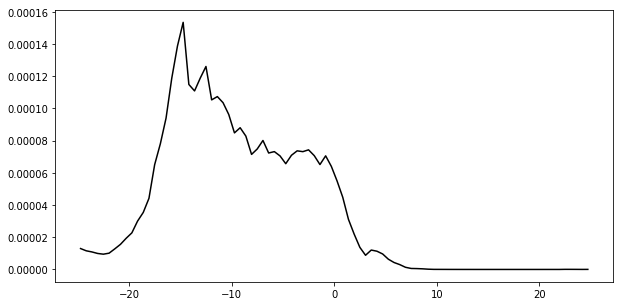

In [14]:
#        # Plot zonal mean rainfall (CHECK LOOKS SENSIBLE)
#        month = 0
#        plot_data = xr.DataArray(pr_cube_zonal_mean[month].data)
#        plot_data.values = pr_cube_zonal_mean[month].data  # Assign good agreement percentages
#        
#        plt.interactive(True)
#        fig, ax1 = plt.subplots(figsize=(10, 5))
#        h = ax1.plot(model_lat.points, plot_data, c='black')
#        plt.interactive(False)

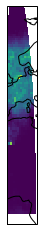

In [26]:
#        # Plot spatial data for region (CHECK LOOKS SENSIBLE)
#        month = 6
#        plot_data = xr.DataArray(pr_data_all[model][month,:,:].data)
#        plot_data.values = pr_data_all[model][month,:,:].data
#        
#        plt.interactive(True)
#        proj = ccrs.Robinson()
#        f, ax = plt.subplots(subplot_kw=dict(projection=proj))
#        h = plot_data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
#        ax.coastlines()
#        plt.interactive(False)